# 1. Overview

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.3 Define Global Variables

In [3]:
# Define the company tickers and names
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited'
}
start_date = '2013-01-01'
end_date = datetime.today().strftime("%Y-%m-%d")
output_data = 'data/weekly_data.csv'

## 2.4 Functions

In [4]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [5]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()

In [6]:
def plot_stock_with_multiple_boxplots(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data.index)

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show();

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show();

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show();


## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [7]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl Zeiss Meditec...
Loading data for Lam Research Corporation...
Loading data for Tokyo Electron Limited...


,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited
Date,,,
2013-01-02,25.741583,1.468380,7.846667
2013-01-03,25.741583,1.439946,7.766667
2013-01-04,25.961220,1.443357,7.700000
2013-01-07,25.961220,1.424401,7.613333
2013-01-08,25.961220,1.402032,7.366667


Now let's plot the stock data

****CARL ZEISS MEDITEC****



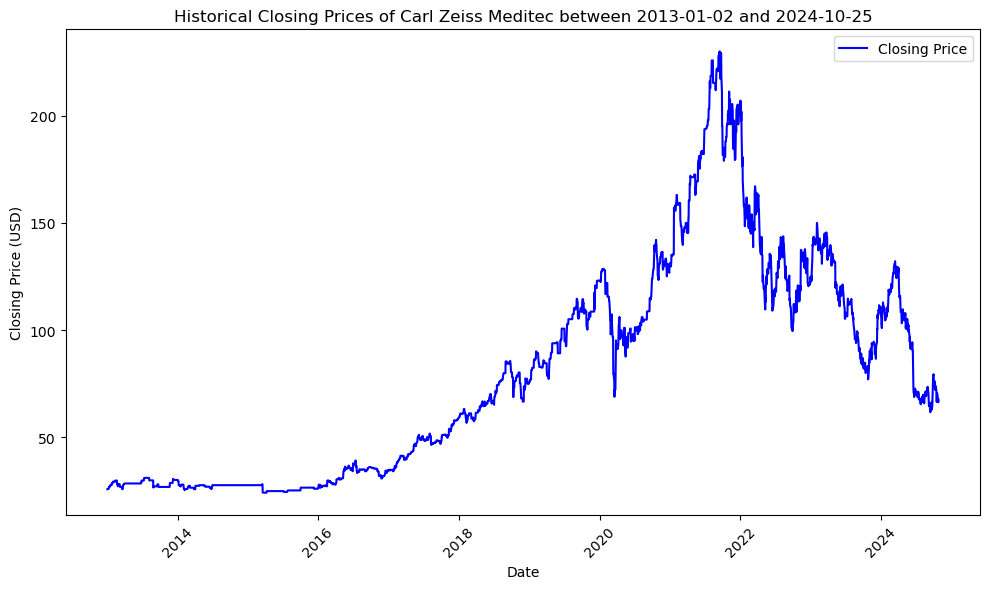


****LAM RESEARCH CORPORATION****



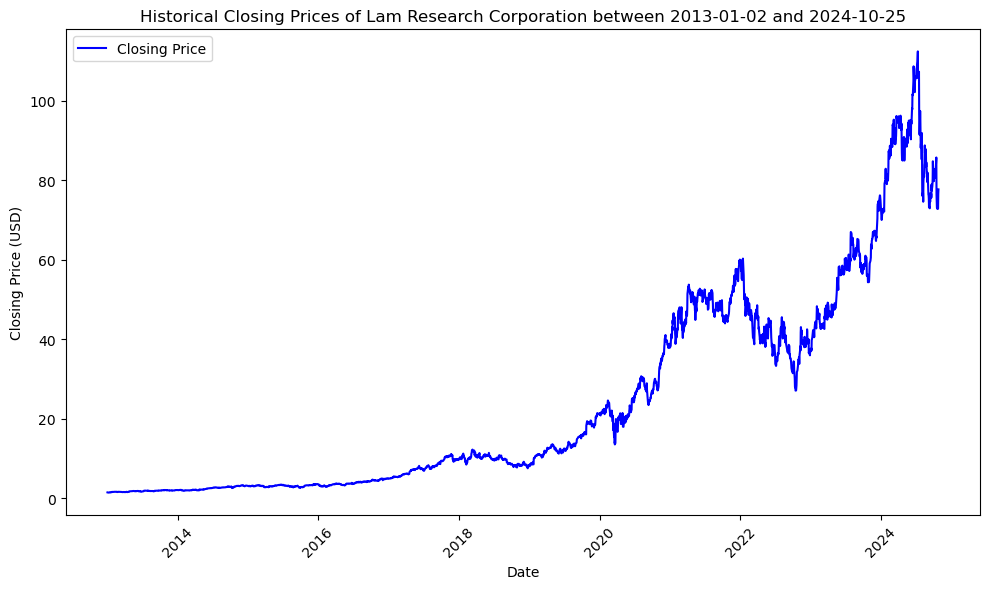


****TOKYO ELECTRON LIMITED****



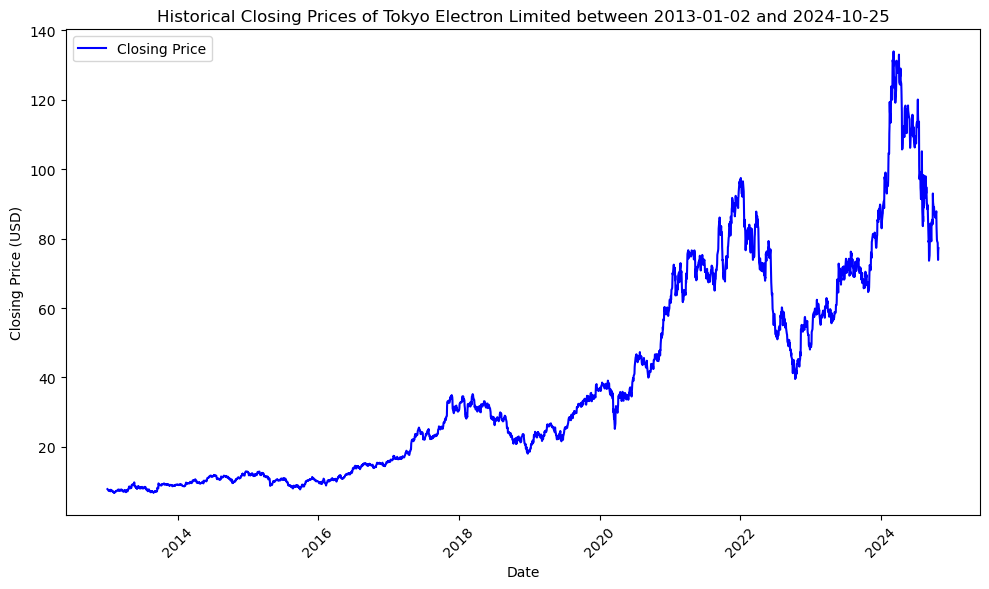

In [8]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company}',company)
    print()

### 2.5.2 Checking for duplicate values

In [9]:
merged_data.duplicated().sum()

0

There are no duplicated values. So we can continue

### 2.5.3 Checking for missing dates

In [10]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl Zeiss Meditec          0.0
Close_Lam Research Corporation    0.0
Close_Tokyo Electron Limited      0.0
dtype: float64

As we can see there aren't any null values

### 2.5.4 Looking at seasonality

****CARL ZEISS MEDITEC****



<Figure size 1200x800 with 0 Axes>

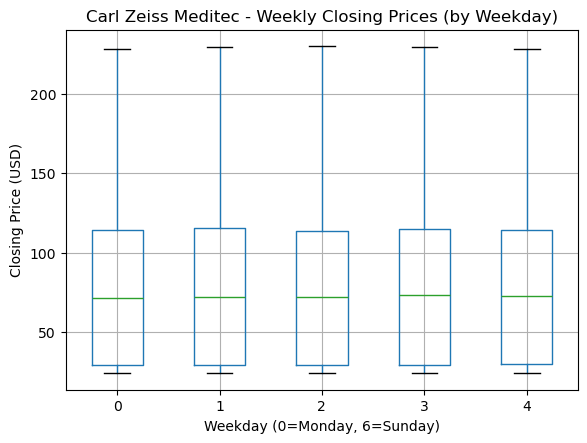

<Figure size 1200x800 with 0 Axes>

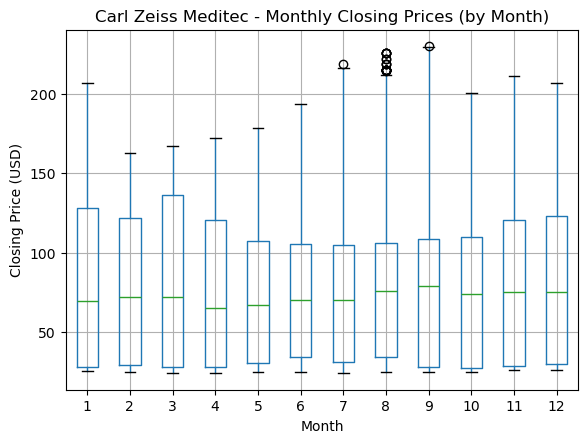

<Figure size 1200x800 with 0 Axes>

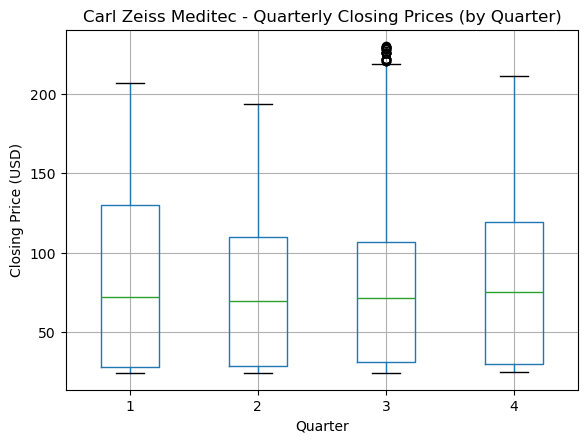


****LAM RESEARCH CORPORATION****



<Figure size 1200x800 with 0 Axes>

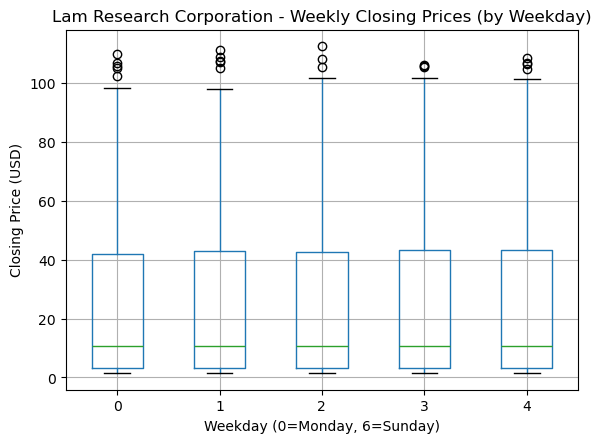

<Figure size 1200x800 with 0 Axes>

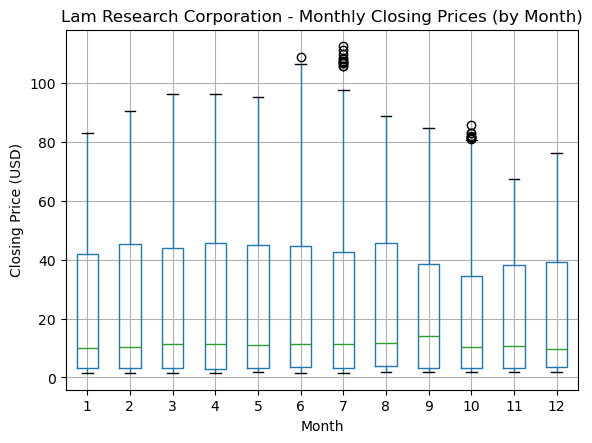

<Figure size 1200x800 with 0 Axes>

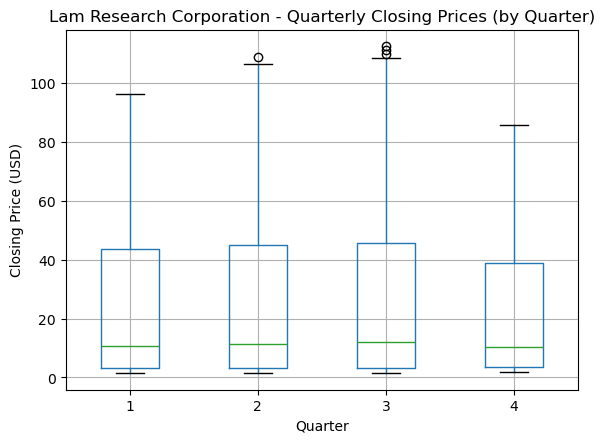


****TOKYO ELECTRON LIMITED****



<Figure size 1200x800 with 0 Axes>

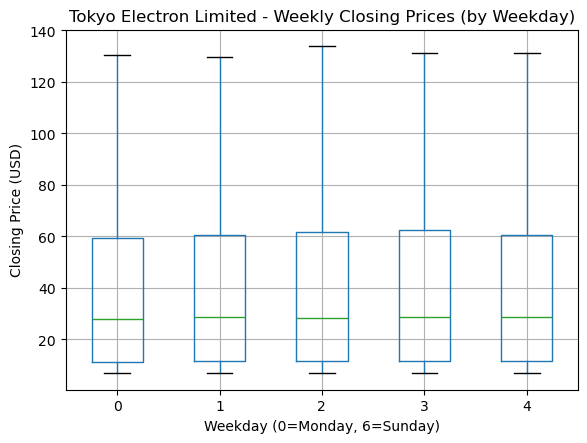

<Figure size 1200x800 with 0 Axes>

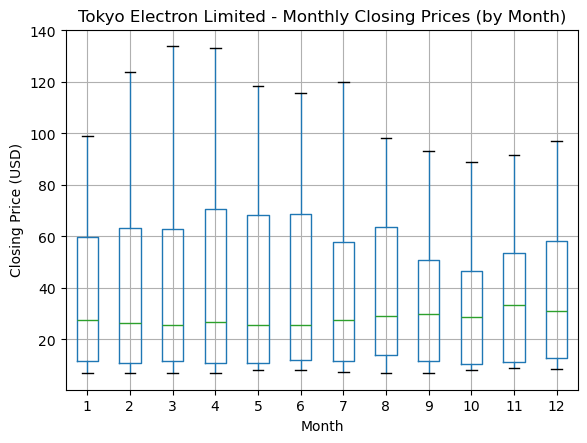

<Figure size 1200x800 with 0 Axes>

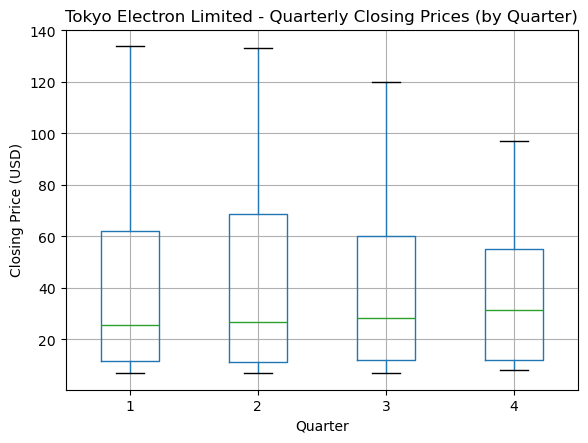

In [11]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_stock_with_multiple_boxplots(merged_data,f'Close_{company}',company)
    print()

With the results above, we cannot determine if there is any clear seasonality for any of the three suppliers. 

### 2.5.5 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [12]:
# Convert the index to a datetime index if it's not already
merged_data.index = pd.to_datetime(merged_data.index)

# Resample the data to weekly frequency and calculate the median
weekly_data = merged_data.resample('W').median()

# Display the weekly data
weekly_data.head()

,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,Date,Weekday,Month,Quarter
Date,,,,,,,
2013-01-06,25.741583,1.443357,7.766667,2013-01-03 00:00:00,3.0,1.0,1.0
2013-01-13,26.057863,1.424401,7.480000,2013-01-09 00:00:00,2.0,1.0,1.0
2013-01-20,27.226337,1.452836,7.460000,2013-01-16 00:00:00,2.0,1.0,1.0
2013-01-27,27.674398,1.519943,7.406667,2013-01-23 12:00:00,2.5,1.0,1.0
2013-02-03,28.728662,1.581741,7.140000,2013-01-30 00:00:00,2.0,1.0,1.0


### 2.5.6 Let's do a prophet model for each supplier

In [13]:
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited'
}

22:24:20 - cmdstanpy - INFO - Chain [1] start processing


Processing Prophet model for: Carl Zeiss Meditec


22:24:20 - cmdstanpy - INFO - Chain [1] done processing


Forecast complete for: Carl Zeiss Meditec
Displaying the last predictions for: Carl Zeiss Meditec
            ds       yhat
617 2024-11-03  69.760163
618 2024-11-10  70.041501
619 2024-11-17  69.579150
620 2024-11-24  68.591615
621 2024-12-01  67.750696
622 2024-12-08  67.644759
623 2024-12-15  68.269163
624 2024-12-22  68.987675
625 2024-12-29  69.048321
626 2025-01-05  68.237853
627 2025-01-12  67.078570
628 2025-01-19  66.347432
Processing Prophet model for: Lam Research Corporation


22:24:20 - cmdstanpy - INFO - Chain [1] start processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing


Forecast complete for: Lam Research Corporation


22:24:21 - cmdstanpy - INFO - Chain [1] start processing
22:24:21 - cmdstanpy - INFO - Chain [1] done processing


Displaying the last predictions for: Lam Research Corporation
            ds       yhat
617 2024-11-03  88.577463
618 2024-11-10  90.271853
619 2024-11-17  91.645551
620 2024-11-24  92.469960
621 2024-12-01  93.015508
622 2024-12-08  93.634996
623 2024-12-15  94.375674
624 2024-12-22  95.031051
625 2024-12-29  95.475780
626 2025-01-05  95.829711
627 2025-01-12  96.284528
628 2025-01-19  96.870511
Processing Prophet model for: Tokyo Electron Limited
Forecast complete for: Tokyo Electron Limited
Displaying the last predictions for: Tokyo Electron Limited
            ds       yhat
617 2024-11-03  91.609176
618 2024-11-10  93.494024
619 2024-11-17  94.949802
620 2024-11-24  95.878055
621 2024-12-01  96.505890
622 2024-12-08  96.948341
623 2024-12-15  97.140120
624 2024-12-22  97.154388
625 2024-12-29  97.358069
626 2025-01-05  98.070122
627 2025-01-12  99.109512
628 2025-01-19  99.871724


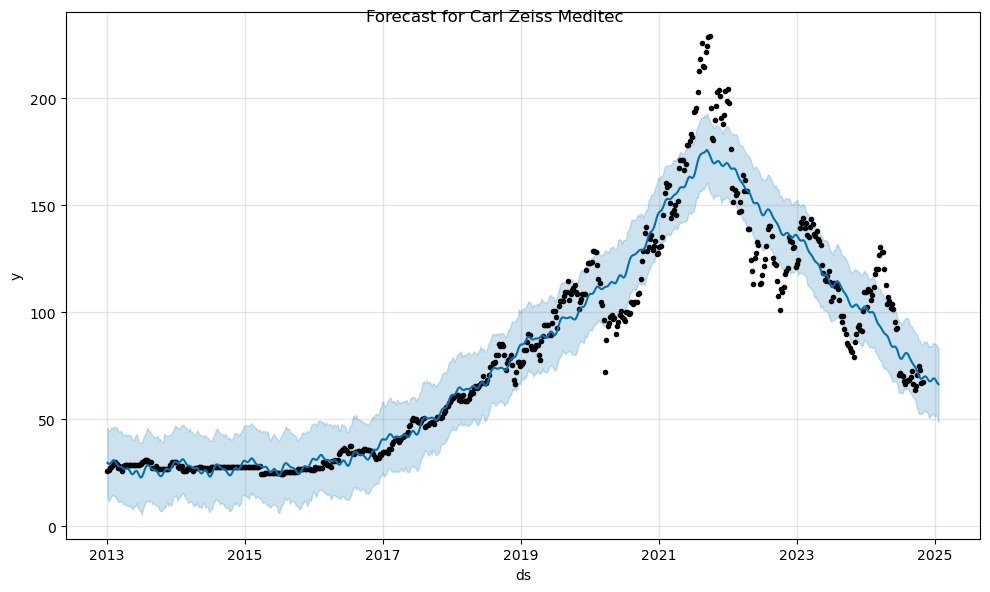

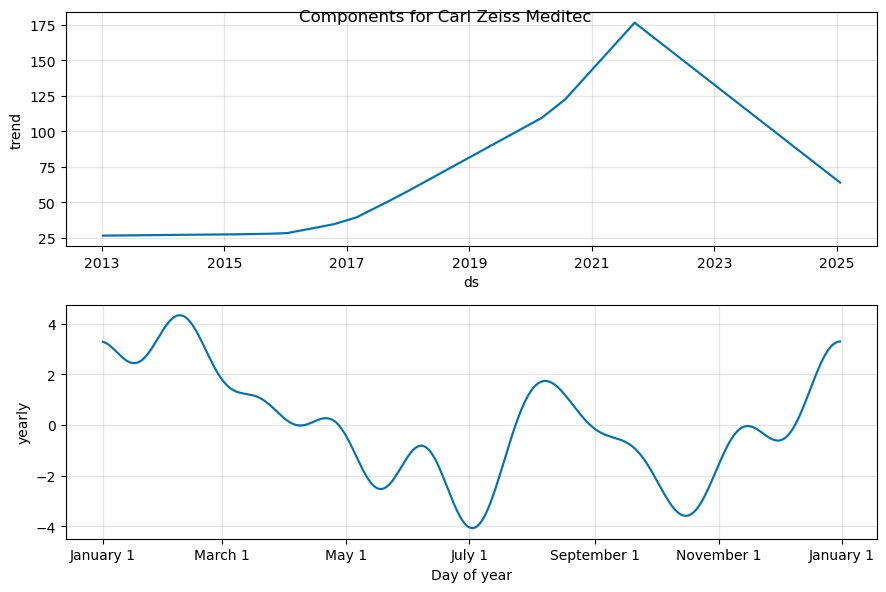

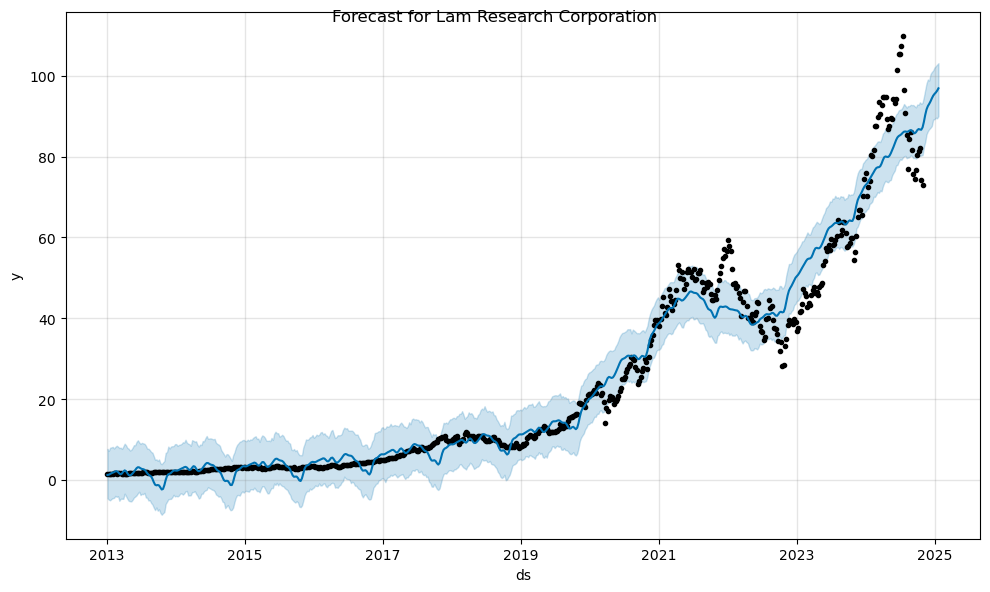

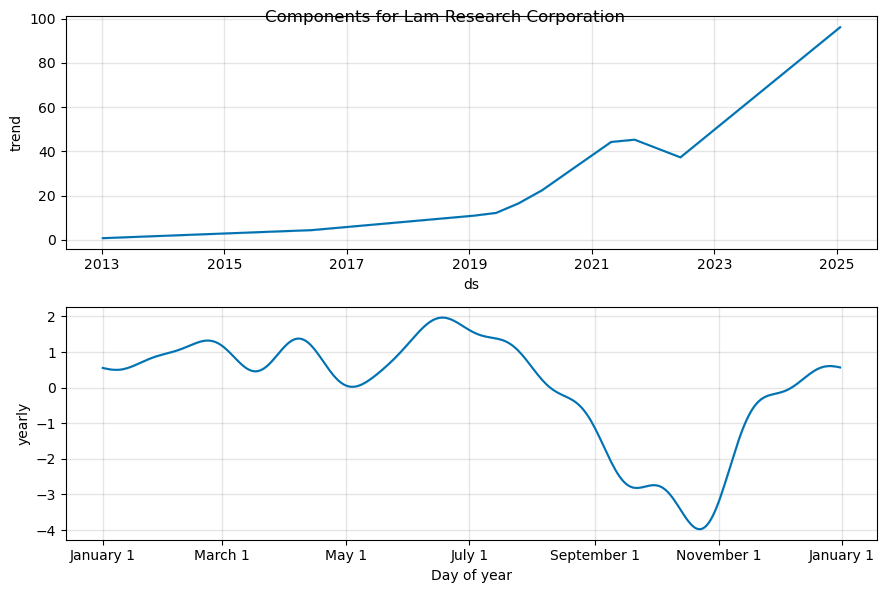

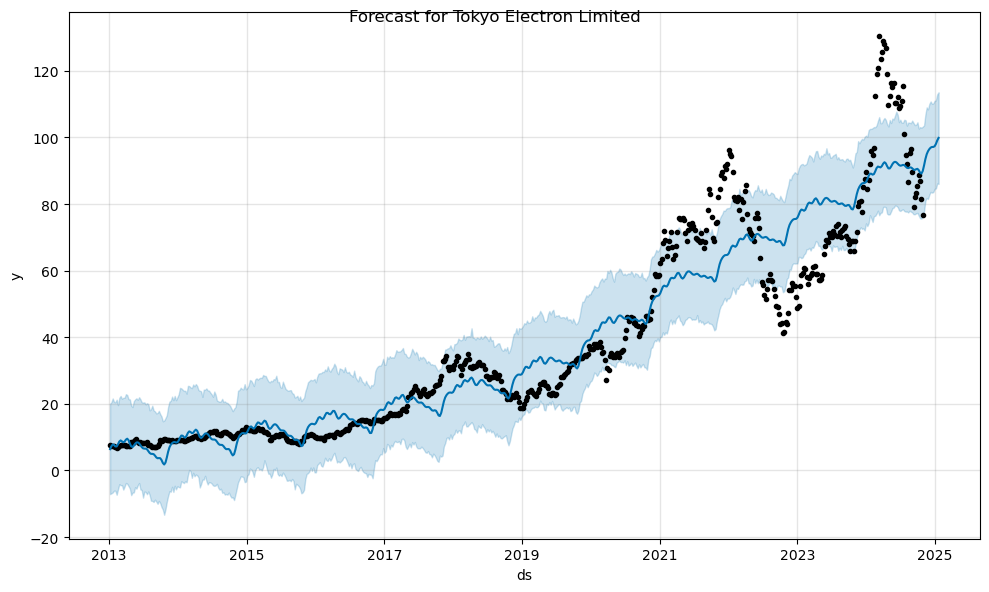

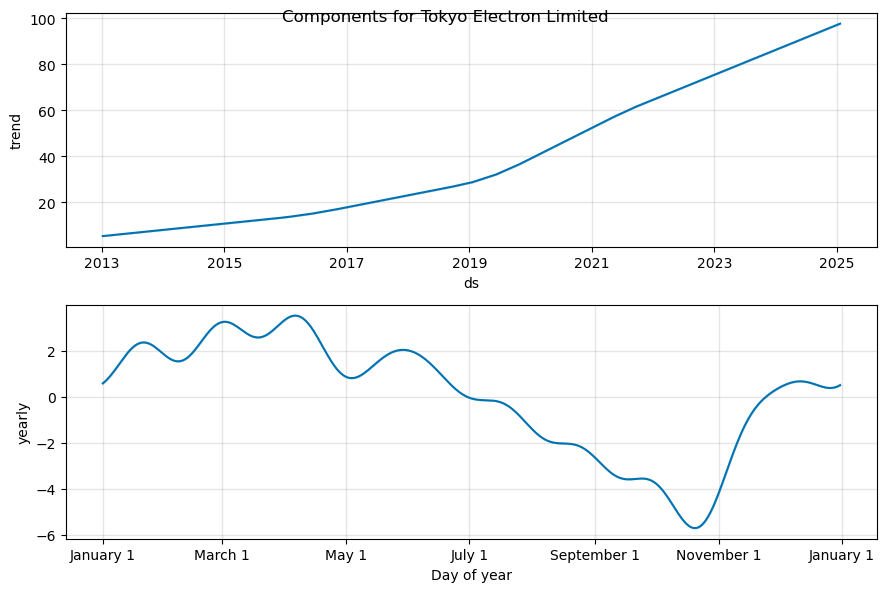

In [16]:
# Dictionary to store the predictions for each company
forecast_dict = {}

# Iterate over each company ticker in the dictionary
for ticker, supplier in company_tickers.items():
    # Create the column name corresponding to the supplier's full name
    column_name = f'Close_{supplier}'
    
    # Check if the column exists in the dataframe
    if column_name in weekly_data.columns:
        # Print the supplier name being processed
        print(f"Processing Prophet model for: {supplier}")
        
        # Prepare the data for Prophet
        train_data_prophet = weekly_data[[column_name]].reset_index()
        train_data_prophet.columns = ['ds', 'y']
        
        # Initialize and fit the Prophet model
        prophet_model = Prophet()
        prophet_model.fit(train_data_prophet)
        
        # Define the forecast horizon (e.g., 12 weeks into the future)
        future = prophet_model.make_future_dataframe(periods=12, freq='W')
        
        # Generate the predictions
        forecast = prophet_model.predict(future)
        
        # Store the predictions in the dictionary
        forecast_dict[supplier] = forecast[['ds', 'yhat']]

        # Print to indicate that the forecast is complete
        print(f"Forecast complete for: {supplier}")

        # Display the complete forecast plot
        fig_forecast = prophet_model.plot(forecast)
        fig_forecast.suptitle(f"Forecast for {supplier}")
        
        # Display the forecast components plot
        fig_components = prophet_model.plot_components(forecast)
        fig_components.suptitle(f"Components for {supplier}")
        
        # Display the last predictions for the supplier
        print(f"Displaying the last predictions for: {supplier}")
        print(forecast_dict[supplier].tail(12))
    else:
        print(f"Column '{column_name}' not found in the dataframe.")


# 3. Export the data

In [30]:
# We just want the "Close" column
weekly_data = weekly_data.drop(['Z_score','Returns'], axis=1)
# Export the weekly_data to a CSV file
weekly_data.to_csv(output_data, index=True, sep=';')